## 1. 작업환경을 현재 위치로 옮긴다.

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

## 2. 필요한 패키지들을 불러온다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, ReLU, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model

In [4]:
from utils.datagenerator import TightFaceProvider
from utils.helper import show_images
from utils.helper import glob_all_files, paths2numpy, images_cropper
from utils.helper import find_all_target, find_max_target, draw_rectangles

## 3. 학습용 데이터를 불러온 후 인공지능 모델 학습에 알맞게 가공해준다.

In [5]:
# 학습 및 검증에 사용될 월리 책 번호
book_number = 1

In [7]:
# 학습에 사용될 이미지들의 경로를 불러온다
fg_folder = [f'./data/book{str(book_number)}/train_imgs/waly_face',
             f'./data/book{str(book_number)}/train_imgs/girl_face',
             f'./data/book{str(book_number)}/train_imgs/magi_face',
             f'./data/book{str(book_number)}/train_imgs/fake_face']

bg_folder = f'./data/book{str(book_number)}/train_imgs/back_imgs'

tfp = TightFaceProvider(fg_folder, bg_folder, batch_size=8)

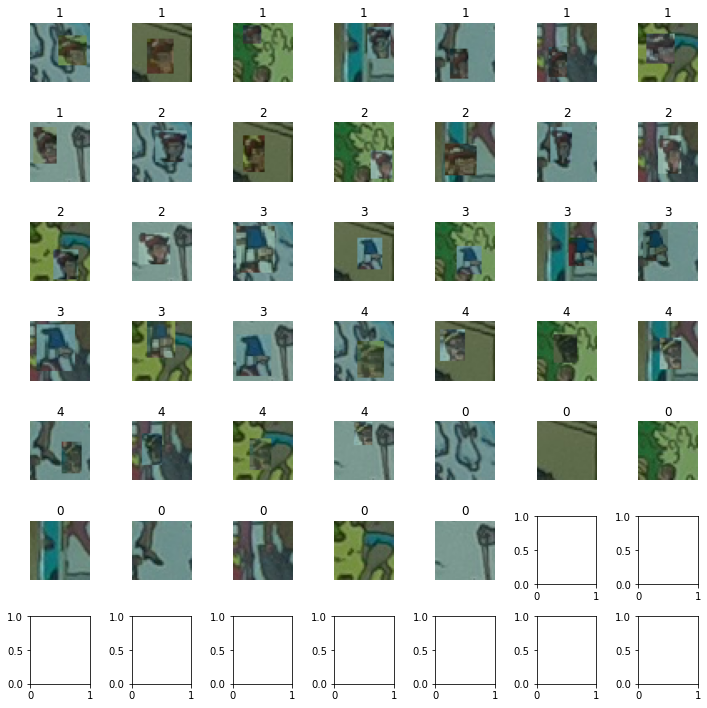

In [8]:
# tfp가 정상적으로 생성되었는지 확인하기 위한 부분
len(tfp)

sample_imgs = tfp[0][0]
sample_labs = tfp[0][1]

show_images(sample_imgs, titles=sample_labs.tolist())

## 4. 학습 모델을 구축한다.

In [9]:
inputs = Input(shape=(36, 36, 3), name='inputs')

conv = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

flat = Flatten()(pool)

#fully connected layer
fcn = Dense(units=256, kernel_initializer='he_normal')(flat)
norm = BatchNormalization()(fcn)
relu = ReLU()(norm)

fcn = Dense(units=256, kernel_initializer='he_normal')(relu)
norm = BatchNormalization()(fcn)
relu = ReLU()(norm)

# 5가지의 카테고리를 softmax를 사용하여 분류
pred = Dense(units=(tfp.path_count+1), activation='softmax')(relu)

# 모델 생성
model = Model(inputs, pred)
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

## 5. 모델을 학습시킨다.

In [10]:
# 학습과 함께 사용될 검증 데이터를 불러오는 부분
val_paths = [f"./data/book{str(book_number)}/valid_imgs/back_imgs",
             f"./data/book{str(book_number)}/valid_imgs/waly_face",
             f"./data/book{str(book_number)}/valid_imgs/girl_face",
             f"./data/book{str(book_number)}/valid_imgs/magi_face",
             f"./data/book{str(book_number)}/valid_imgs/fake_face"]

paths = glob_all_files(val_paths)

# 검증용 이미지들을 가져온다
val_images = []
path_count = 0

for path in paths:
    images = paths2numpy(path)

    if not images:
        continue

    path_count += 1
    val_images.append(images)

assert path_count > 0, print("올바른 경로가 아니거나, 모든 경로 내에 검증용 이미지가 존재하지 않습니다.")

# 검증용 라벨들을 만든다
val_labels = []
for i in range(path_count):
    val_labels.extend(np.full(len(val_images[i]), i))

# list 형태의 test_images unlist 해주는 부분
val_images = [y for x in val_images for y in x]

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [ ]:
# 인공지능 모델을 학습시키는 부분, history: overfitting을 체크하기 위한 변수
history = model.fit(tfp, epochs=1, validation_data=(test_images, test_labels))

In [ ]:
print(history.history['loss'])
print(history.history['sparse_categorical_accuracy'])
print(history.history['val_loss'])
print(history.history['val_sparse_categorical_accuracy'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

## 6. 모델을 저장한다.

In [ ]:
# model.save("./models/book1_model")

## 7. 이미 저장된 모델이 있을 경우, 그 모델을 불러온다.

In [11]:
model = load_model("./models/book1_model")

## 8. 검증용 데이터를 불러온다.

## 9. 모델을 검증용 데이터로 테스트합니다.

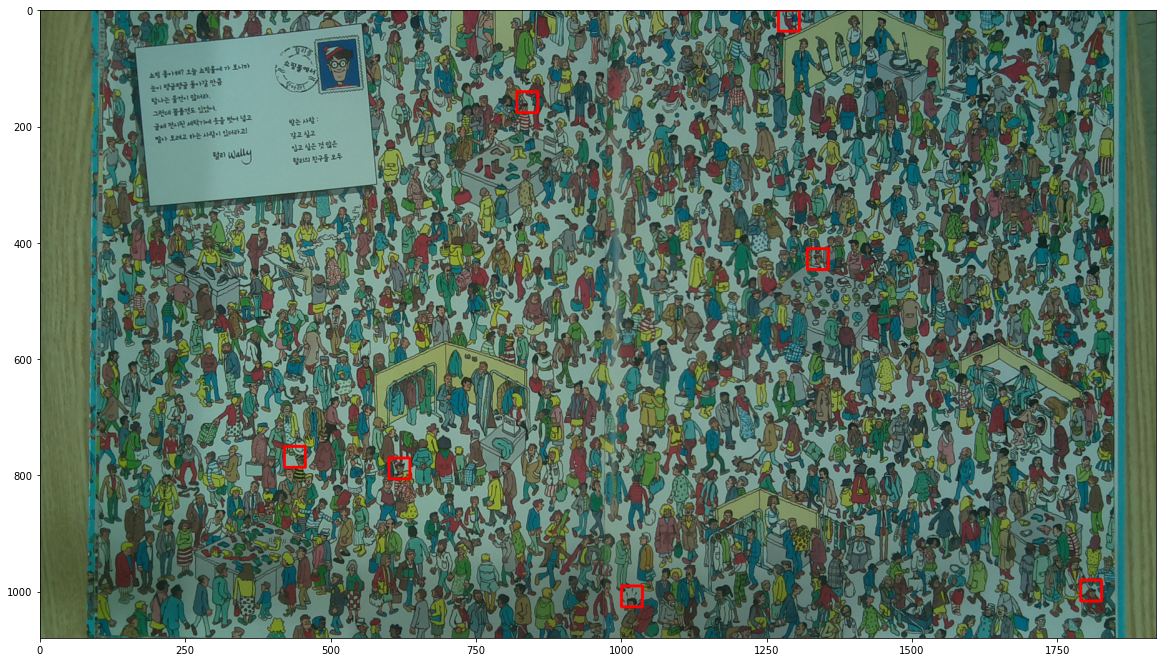

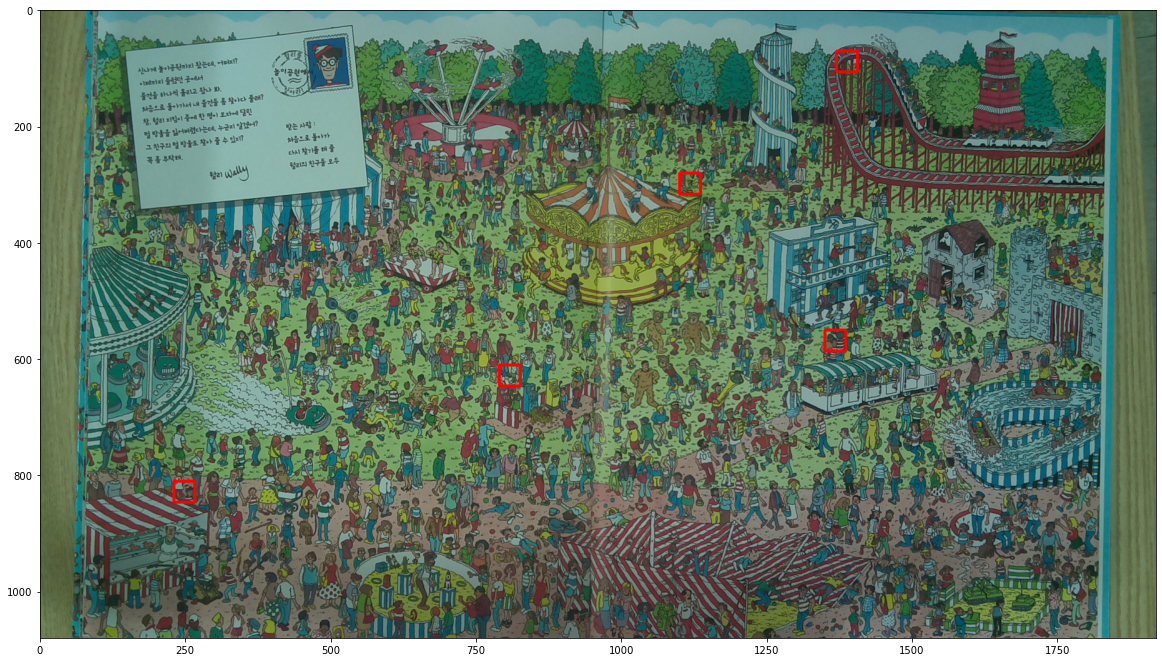

In [13]:
val_folder = f"./data/book{str(book_number)}/test_imgs"
imgs = glob_all_files(val_folder)

assert imgs, print("올바른 경로가 아니거나, 경로 내에 검증용 전체 이미지가 존재하지 않습니다.")

imgs = paths2numpy(imgs)

bucket_crop_imgs, bucket_crop_crds = images_cropper(imgs, 10, 10, 36, 36)

for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)

    # mask 를 생성하는 함수들 입니다. 둘 중에서 원하는 방식을 사용할 수 있습니다.
    # find_non_background: 학습 모델이 이미지에서 배경이라고 판단하지 않은 부분의 인덱스들을 가져옵니다.
    #                      limit 변수에 0이상 1미만의 값을 넣을 경우, 해당 값을 초과하는 예측값을 가진 부분의 인덱스들만을 가져옵니다.

    # 두 함수 모두, target 부분에 넣는 인자에 따라 특정 캐릭터의 예측 위치를 가져올 수 있습니다.
    # 0: 모든 캐릭터, 1: 월리, 2: 여자친구, 3: 마법사, 4: 가짜
    mask = find_all_target(predicts, limit=0, target=0)

    # show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[mask]  # 찾고자 하는 캐릭터의 얼굴이 있을 것으로 예상되는 좌표들을 저장
    predicts = predicts[mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장

    # 각 행들의 최대 예측값을 저장
    predicts = np.max(predicts, axis=1)

    # 학습 모델이 목표로 잡은 곳에 빨간 사각형을 그린 후 해당 이미지를 저장한다.
    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts)

    # 결과 이미지를 화면에 보여준다
    plt.figure(figsize=(20, 20))
    plt.imshow(result_image)
    plt.show()

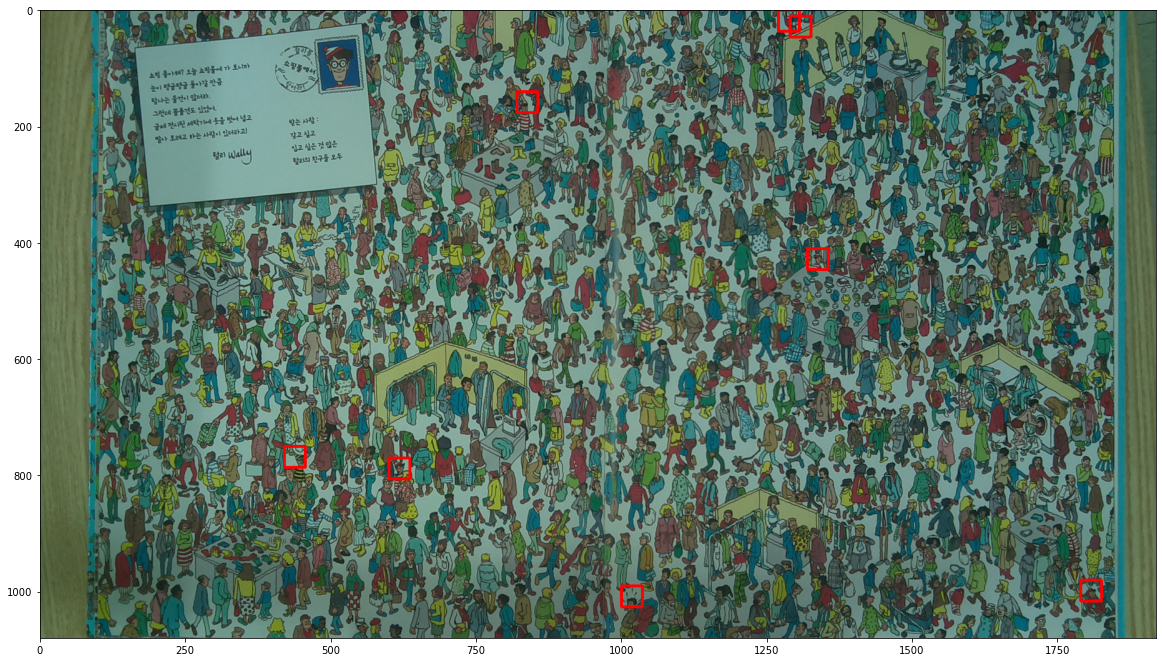

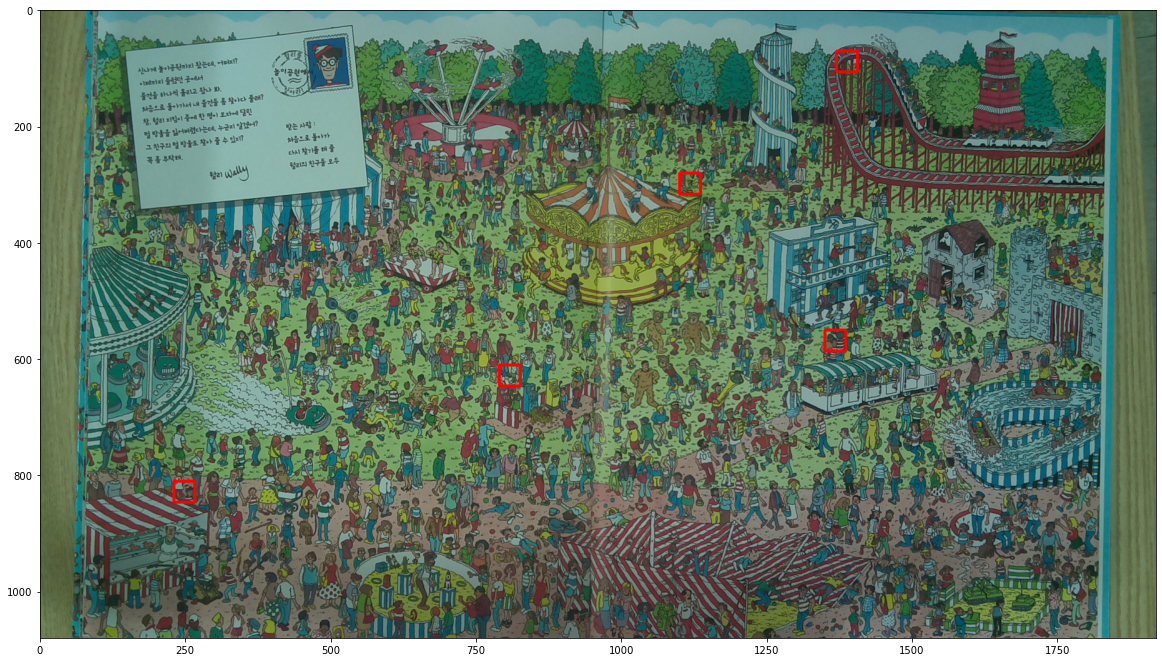

In [14]:
val_folder = f"./data/book{str(book_number)}/test_imgs"
imgs = glob_all_files(val_folder)

assert imgs, print("올바른 경로가 아니거나, 경로 내에 검증용 전체 이미지가 존재하지 않습니다.")

imgs = paths2numpy(imgs)

bucket_crop_imgs, bucket_crop_crds = images_cropper(imgs, 10, 10, 36, 36)

for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)

    # mask 를 생성하는 함수들 입니다. 둘 중에서 원하는 방식을 사용할 수 있습니다.
    # find_max_prediction: 학습 모델이 이미지에서 목표 캐릭터의 얼굴일 확률이 가장 높은 부분의 인덱스들을 가져옵니다.

    # 두 함수 모두, target 부분에 넣는 인자에 따라 특정 캐릭터의 예측 위치를 가져올 수 있습니다.
    # 0: 모든 캐릭터, 1: 월리, 2: 여자친구, 3: 마법사, 4: 가짜
    mask = find_max_target(predicts, target=0)

    # show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[mask]  # 찾고자 하는 캐릭터의 얼굴이 있을 것으로 예상되는 좌표들을 저장
    predicts = predicts[mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장

    # 각 행들의 최대 예측값을 저장
    predicts = np.max(predicts, axis=1)

    # 학습 모델이 목표로 잡은 곳에 빨간 사각형을 그린 후 해당 이미지를 저장한다.
    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts)

    # 결과 이미지를 화면에 보여준다
    plt.figure(figsize=(20, 20))
    plt.imshow(result_image)
    plt.show()